<a href="https://colab.research.google.com/github/astro-informatics/tutorial_harmonic/blob/main/tutorial.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
%%capture
if 'google.colab' in str(get_ipython()):
    # Install packages
    %pip install harmonic emcee getdist

In [ ]:
%%capture
# Import modules
import numpy as np
import matplotlib.pyplot as plt
import harmonic as hm
from functools import partial
import emcee
import jax.numpy as jnp

# Part 1. Basic usage

### Define Bayesian posterior function
---

Now we will need to define the log-posterior function of interest. 

As a working example for this basic tutorial we consider a log-likelihood given a standard 2-dimensional Gaussian

$$
f(x) = -\frac{1}{2}x^{T}\Sigma^{-1}x
$$

where for simplicity we have taken the mean $\mu=0$ and dropped scaling factors, and assume a trivial uniform prior over an infinite interval. Under such conditions the log-posterior is given by

In [ ]:
def ln_posterior(x, inv_cov):
    """Compute log_e of posterior of n dimensional multivariate Gaussian.

    Args:

        x: Position at which to evaluate posterior.

    Returns:

        double: Value of posterior at x.

    """

    return -jnp.dot(x,jnp.dot(inv_cov,x))/2.0

### Compute samples using `emcee`
---

We then sample from the posterior using an MCMC algorithm. While any MCMC approach can be used we sample using the `emcee` package.

First we will need to define and initialise some variables.

In [ ]:
# Define parameters for emcee sampling
ndim = 5                    # Dimensions
nchains = 30                # total number of chains to compute
samples_per_chain = 5000    # number of samples per chain
nburn = 2000                # number of samples to discard as burn in

# Construct a trivial inverse covariance (identity matrix)
inv_cov = np.zeros((ndim,ndim))
diag_cov = np.ones(ndim)
np.fill_diagonal(inv_cov, diag_cov) 

Now we need to run the sampler.

In [ ]:
# initialise random seed
np.random.seed(1)

# Set initial random position and state
pos = np.random.rand(ndim * nchains).reshape((nchains, ndim)) 
rstate = np.random.get_state()

# Instantiate and execute sampler 
sampler = emcee.EnsembleSampler(nchains, ndim, ln_posterior, args=[inv_cov])
(pos, prob, state) = sampler.run_mcmc(pos, samples_per_chain, rstate0=rstate) 

# Collect samples into contiguous numpy arrays (discarding burn in)
samples = np.ascontiguousarray(sampler.chain[:,nburn:,:])
lnprob = np.ascontiguousarray(sampler.lnprobability[:,nburn:])

## Compute evidence using `harmonic`
---

`harmonic` requires only posterior samples.  There are no constraints on the type of sampling algorithm used.

Once we have posterior samples to hand, they can be post-processed using `harmonic` to compute the Bayesian evidence.

### Collating samples using `harmonic.chains` class

We first configure the chains into a `harmonic`-friendly shape, which we do as follows.

In [ ]:
# Instantiate harmonic's chains class 
chains = hm.Chains(ndim)
chains.add_chains_3d(samples, lnprob)

Since we will subsequently learn the target distribution $\varphi$ we split the samples into training and inference sets (we often use the common machine learning terminology "test" for the inference data-set).

In [ ]:
# Split the chains into the ones which will be used to train the machine 
# learning model and for inference
chains_train, chains_infer = hm.utils.split_data(chains, training_proportion=0.5)

### Train the machine learning model

We simply select the model we wish to adopt and fit the model.

In [ ]:
# Select RQSpline Model
temperature = 0.8
model = hm.model.RQSplineModel(ndim, standardize=True, temperature=temperature)
epochs_num = 15
# Train model
model.fit(chains_train.samples, epochs=epochs_num, verbose= True)

Training NF: 100%|██████████| 15/15 [00:34<00:00,  2.27s/it]


### Posterior triangle plot

Let's also plot slices of the posterior using these samples to see what we're working with! It is important for the concentrated flow (here we set temperature equal to 0.8) to be contained within the posterior. If this is not the case, the evidence estimate will not be accurate. If the flow is not contained within the posterior, try reducing the temperature or learning the posterior better by training for longer or changing the model architecture or hyperparameters.

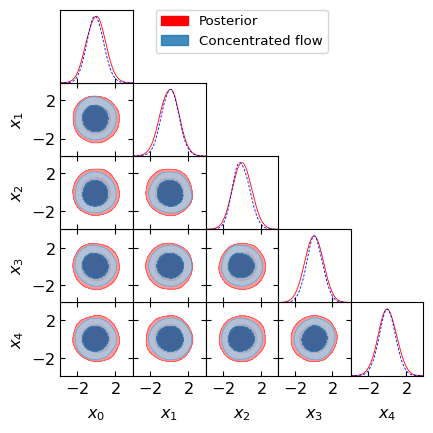

In [ ]:
samples = samples.reshape((-1, ndim))
samp_num = samples.shape[0]
flow_samples = model.sample(samp_num)
hm.utils.plot_getdist_compare(samples, flow_samples)

### Compute the Bayesian evidence

Finally we simply compute the learnt harmonic mean estimator as follows.

In [ ]:
# Instantiate harmonic's evidence class
ev = hm.Evidence(chains_infer.nchains, model)

# Pass the evidence class the inference chains and compute the evidence!
ev.add_chains(chains_infer)
ln_inv_evidence = ev.ln_evidence_inv
err_ln_inv_evidence = ev.compute_ln_inv_evidence_errors()

## Results
---

Let's check the evidence value computed.

### Analytic value

As this is a standard 2-dimensional Gaussian the evidence is analytically tractable and given by

In [ ]:
def ln_analytic_evidence(ndim, cov):
    """Compute analytic evidence for nD Gaussian.

    Args:

        ndim: Dimension of Gaussian.

        cov: Covariance matrix.

    Returns:

        double: Analytic evidence.

    """
    
    ln_norm_lik = 0.5*ndim*np.log(2*np.pi) + 0.5*np.log(np.linalg.det(cov))
    return ln_norm_lik

ln_inv_evidence_analytic = -ln_analytic_evidence(ndim, inv_cov)

Let's compare the value computed by `harmonic` and analytically

In [ ]:
print('ln inverse evidence (harmonic) = {} +/- {}'.format(ln_inv_evidence, err_ln_inv_evidence))
print('ln inverse evidence (analytic) = {}'.format(ln_inv_evidence_analytic))
print('nsigma = {}'.format(np.abs(ln_inv_evidence - ln_inv_evidence_analytic) / err_ln_inv_evidence))

ln inverse evidence (harmonic) = -4.588324546813965 +/- (np.float32(-0.007659368), np.float32(0.0076011475))
ln inverse evidence (analytic) = -4.594692666023363
nsigma = [-0.83141573  0.83778393]


As expected, the evidence computed by `harmonic` is close to that computed analytically.

# Part 2. Diagnostics

# Part 3. Polynomial/radiata pine

In [ ]:
# Set random seed for reproducibility
np.random.seed(42)


# Helper: evaluate polynomial given coefficients in increasing power order
def model_predict(params, x):
    """Evaluate polynomial with coefficients `params = [a0, a1, ...]`
    
    Returns y = a0 + a1*x + a2*x^2 + ...

    `np.polyval` expects highest-to-lowest order, so we flip.
    """
    y = np.polyval(np.flip(params), x)
    return y

## Generate synthetic data

Generate a small synthetic dataset by selecting a polynomial order and
adding Gaussian observation noise.

In [ ]:
print("--- Generating synthetic data ---")

"""
Configuration: select ground-truth model and parameters.

Options for `truth_model`: 'linear', 'quadratic', 'cubic', 'quartic'.
"""

# Choose the underlying truth model
truth_model = "cubic"  # options: 'linear', 'quadratic', 'cubic', 'quartic'

# Observation settings
noise_std = 2.0  # Standard deviation of the Gaussian noise
num_data_points = 20
x_data = np.linspace(-3, 3, num_data_points)

# True polynomial coefficients (a_k corresponds to x^k)
a0_true = -2.0  # constant term
a1_true = -1.0  # linear term
a2_true = 0.2  # quadratic term
a3_true = 0.5  # cubic term
a4_true = 0.0  # quartic term

if truth_model == "linear":
    y_true_noiseless = model_predict([a0_true, a1_true], x_data)
elif truth_model == "quadratic":
    y_true_noiseless = model_predict([a0_true, a1_true, a2_true], x_data)
elif truth_model == "cubic":
    y_true_noiseless = model_predict([a0_true, a1_true, a2_true, a3_true], x_data)
elif truth_model == "quartic":
    y_true_noiseless = model_predict(
        [a0_true, a1_true, a2_true, a3_true, a4_true], x_data
    )
else:
    raise ValueError(
        "Truth_model must be one of 'linear', 'quadratic', 'cubic', 'quartic'"
    )

# Add Gaussian noise to y values
y_data = y_true_noiseless + np.random.normal(
    loc=0.0, scale=noise_std, size=num_data_points
)

--- Generating synthetic data ---


## Log-likelihood

The log-likelihood assumes independent Gaussian measurement noise with
known standard deviation, and is defined as follows:

  $$\hat{y}(x;a)=\sum_{k=0}^n a_k x^k$$

- Gaussian log-likelihood with known noise standard deviation $\sigma$:

  $$\ln P(y\mid x,a) = -\tfrac{1}{2}\sum_i\left(\frac{(y_i-\hat{y}(x_i;a))^2}{\sigma^2} + \ln(2\pi\sigma^2)\right).$$

In [ ]:
def log_likelihood(params, x, y, noise_std, order):
    model_prediction = model_predict(params, x)
    sigma2 = noise_std**2
    diff = y - model_prediction
    log_likelihood_val = -0.5 * np.sum(diff**2 / sigma2 + np.log(2 * np.pi * sigma2))
    return log_likelihood_val

## Prior

We use independent uniform priors for each polynomial coefficient. 

$$
\ln\pi(\theta)=\begin{cases}
-\sum_{i=0}^{D-1}\ln(b_i-a_i), & \text{if } a_i\le\theta_i\le b_i\ \forall i,\\
-\infty, & \text{otherwise.}
\end{cases}
$$

In [ ]:
def log_prior(params, bounds):
    """Log-density of independent uniform priors.

    Args:
        params (array-like): parameter vector of shape (D,).
        bounds (sequence): sequence of (low, high) pairs length D.

    Returns:
        float: log prior (finite) when all params within bounds, otherwise -inf.
    """
    params = np.asarray(params)
    bnds = np.asarray(bounds, dtype=float)

    lows = bnds[:, 0]
    highs = bnds[:, 1]

    widths = highs - lows
    return -np.sum(np.log(widths))

## Model posteriors and prior bounds

We define a log-posterior function for each polynomial model (linear,
quadratic, cubic, quartic). Each posterior is the sum of the uniform prior
and the Gaussian log-likelihood. Bounds are set once here for consistency.

In [ ]:
bound = 2.5
param_bounds_linear = [(-bound, bound)] * 2
param_bounds_quadratic = [(-bound, bound)] * 3
param_bounds_cubic = [(-bound, bound)] * 4
param_bounds_quartic = [(-bound, bound)] * 5


# Model A: Linear (Order 1)
def log_posterior_linear(params):
    lp = log_prior(params, param_bounds_linear)
    if not np.isfinite(lp):
        return -np.inf
    return lp + log_likelihood(params, x_data, y_data, noise_std, order=1)


# Model B: Quadratic (Order 2) - The True Model
def log_posterior_quadratic(params):
    lp = log_prior(params, param_bounds_quadratic)
    if not np.isfinite(lp):
        return -np.inf
    return lp + log_likelihood(params, x_data, y_data, noise_std, order=2)


# Model C: Cubic (Order 3)
def log_posterior_cubic(params):
    lp = log_prior(params, param_bounds_cubic)
    if not np.isfinite(lp):
        return -np.inf
    return lp + log_likelihood(params, x_data, y_data, noise_std, order=3)


# Model D: Quartic (Order 4)
def log_posterior_quartic(params):
    lp = log_prior(params, param_bounds_quartic)
    if not np.isfinite(lp):
        return -np.inf
    return lp + log_likelihood(params, x_data, y_data, noise_std, order=4)

## MCMC sampling with emcee

Run an `emcee` ensemble per model to obtain posterior samples.

In [ ]:
print("\n--- Running MCMC with emcee ---")

# Define common emcee sampling parameters
nwalkers = 16  # Number of MCMC walkers
nsteps = 1000  # Number of steps per walker
nburn = 500  # Number of burn-in steps to discard


# Helper function to run emcee and return samples
def run_mcmc_sampler(log_posterior_func, ndim, initial_guess, model_name):
    """
    Runs the emcee sampler for a given log-posterior function.

    Args:
        log_posterior_func (callable): The log-posterior function.
        ndim (int): The number of dimensions (parameters) for the model.
        initial_guess (np.ndarray): An initial guess for the parameters.
        model_name (str): Name of the model for printing progress.

    Returns:
        np.ndarray: 3D array of posterior samples after burn-in (nwalkers, nsteps-nburn, ndim).
        np.ndarray: 2D array of log-probabilities after burn-in (nwalkers, nsteps-nburn).
    """
    print(f"  Sampling for {model_name} model ({ndim} parameters)...")

    # Initialize walkers in a small ball around the initial guess
    pos = initial_guess + 1e-4 * np.random.randn(nwalkers, ndim)

    # Instantiate the sampler
    sampler = emcee.EnsembleSampler(nwalkers, ndim, log_posterior_func)

    # Run the MCMC
    sampler.run_mcmc(pos, nsteps, progress=True)

    # Get the chain of samples and log-probabilities, discarding burn-in
    samples = np.ascontiguousarray(sampler.chain[:, nburn:, :])
    log_prob = np.ascontiguousarray(sampler.lnprobability[:, nburn:])

    print(
        f"  Finished sampling for {model_name}. Collected {samples.shape[0] * samples.shape[1]} samples."
    )
    return samples, log_prob


# Initial guesses for parameters (can be based on true values or rough estimates)
# For linear: [a_0, a_1]
initial_guess_linear = np.array([a0_true, a1_true])
# For quadratic: [a_0, a_1, a_2]
initial_guess_quadratic = np.array([a0_true, a1_true, a2_true])
# For cubic: [a_0, a_1, a_2, a_3]
initial_guess_cubic = np.array([a0_true, a1_true, a2_true, a3_true])
# For quartic: [a_0, a_1, a_2, a_3, a_4]
initial_guess_quartic = np.array(
    [a0_true, a1_true, a2_true, a3_true, a4_true if a4_true != 0 else 0.01]
)

# Run MCMC for each model
samples_linear, log_prob_linear = run_mcmc_sampler(
    log_posterior_linear,
    ndim=2,
    initial_guess=initial_guess_linear,
    model_name="linear (order 1)",
)
samples_quadratic, log_prob_quadratic = run_mcmc_sampler(
    log_posterior_quadratic,
    ndim=3,
    initial_guess=initial_guess_quadratic,
    model_name="quadratic (order 2)",
)
samples_cubic, log_prob_cubic = run_mcmc_sampler(
    log_posterior_cubic,
    ndim=4,
    initial_guess=initial_guess_cubic,
    model_name="cubic (order 3)",
)
samples_quartic, log_prob_quartic = run_mcmc_sampler(
    log_posterior_quartic,
    ndim=5,
    initial_guess=initial_guess_quartic,
    model_name="quartic (order 4)",
)


--- running mcmc with emcee ---
  Sampling for linear (order 1) model (2 parameters)...


100%|██████████| 1000/1000 [00:00<00:00, 2959.47it/s]


  Finished sampling for linear (order 1). Collected 8000 samples.
  Sampling for quadratic (order 2) model (3 parameters)...


100%|██████████| 1000/1000 [00:00<00:00, 3169.10it/s]


  Finished sampling for quadratic (order 2). Collected 8000 samples.
  Sampling for cubic (order 3) model (4 parameters)...


100%|██████████| 1000/1000 [00:00<00:00, 3087.22it/s]


  Finished sampling for cubic (order 3). Collected 8000 samples.
  Sampling for quartic (order 4) model (5 parameters)...


100%|██████████| 1000/1000 [00:00<00:00, 3127.52it/s]

  Finished sampling for quartic (order 4). Collected 8000 samples.


## Evidence estimation with harmonic

In [ ]:
print("\n--- Computing log-evidence with harmonic ---")

# Define common harmonic parameters
training_proportion = 0.5  # Proportion of samples to use for training the flow model
temperature = 0.8  # Temperature parameter for the RQSplineModel


# Helper function to compute log-evidence for a given model
def compute_log_evidence(samples, log_prob, ndim, model_name):
    """Compute ln(Z) and an approximate error using harmonic's normalizing flow.

    This helper trains a flow on a split of the provided posterior samples and
    uses harmonic's Evidence object to obtain an estimate of the inverse
    evidence. The function returns ln(Z) and a symmetric error estimate.
    """
    print(f"  Computing log-evidence for {model_name} model...")

    chains = hm.Chains(ndim)
    chains.add_chains_3d(samples, log_prob)

    chains_train, chains_infer = hm.utils.split_data(
        chains, training_proportion=training_proportion
    )

    model = hm.model.RQSplineModel(ndim, standardize=True, temperature=temperature)
    epochs_num = 10
    print(f"    Training RQSplineModel for {model_name} with {epochs_num} epochs...")
    model.fit(chains_train.samples, epochs=epochs_num, verbose=False)

    ev = hm.Evidence(chains_infer.nchains, model)
    ev.add_chains(chains_infer)

    ln_evidence_inv = ev.ln_evidence_inv
    err_tuple = ev.compute_ln_inv_evidence_errors()
    err_ln_evidence_inv = (abs(err_tuple[0]) + abs(err_tuple[1])) / 2

    return -ln_evidence_inv, err_ln_evidence_inv


# Compute log-evidence for each model
ln_Z_linear, err_ln_Z_linear = compute_log_evidence(
    samples=samples_linear,
    log_prob=log_prob_linear,
    ndim=2,
    model_name="linear (order 1)",
)
ln_Z_quadratic, err_ln_Z_quadratic = compute_log_evidence(
    samples=samples_quadratic,
    log_prob=log_prob_quadratic,
    ndim=3,
    model_name="quadratic (order 2)",
)
ln_Z_cubic, err_ln_Z_cubic = compute_log_evidence(
    samples=samples_cubic, log_prob=log_prob_cubic, ndim=4, model_name="cubic (order 3)"
)
ln_Z_quartic, err_ln_Z_quartic = compute_log_evidence(
    samples=samples_quartic,
    log_prob=log_prob_quartic,
    ndim=5,
    model_name="quartic (order 4)",
)


--- Computing log-evidence with harmonic ---
  Computing log-evidence for linear (order 1) model...
    Training RQSplineModel for linear (order 1) with 10 epochs...
  Computing log-evidence for quadratic (order 2) model...
    Training RQSplineModel for quadratic (order 2) with 10 epochs...
  Computing log-evidence for cubic (order 3) model...
    Training RQSplineModel for cubic (order 3) with 10 epochs...
  Computing log-evidence for quartic (order 4) model...
    Training RQSplineModel for quartic (order 4) with 10 epochs...


## Evidence table

Compare log-evidence (ln Z) and estimated errors across models.

In [ ]:
print("\n--- log-evidence comparison ---")
print("| model           | log-evidence (ln Z) | error (ln Z) |")
print("|-----------------|---------------------|--------------|")
print(f"| linear (order 1)| {ln_Z_linear:^20.3f}| {err_ln_Z_linear:^13.3f}|")
print(f"| quadratic (order 2)| {ln_Z_quadratic:^20.3f}| {err_ln_Z_quadratic:^13.3f}|")
print(f"| cubic (order 3) | {ln_Z_cubic:^20.3f}| {err_ln_Z_cubic:^13.3f}|")
print(f"| quartic (order 4)| {ln_Z_quartic:^20.3f}| {err_ln_Z_quartic:^13.3f}|")


--- log-evidence comparison ---
| model           | log-evidence (ln Z) | error (ln Z) |
|-----------------|---------------------|--------------|
| linear (order 1)|       -60.690       |     0.010    |
| quadratic (order 2)|       -63.083       |     0.028    |
| cubic (order 3) |       -46.994       |     0.074    |
| quartic (order 4)|       -50.647       |     0.064    |


In [ ]:
# --- Helper plotting functions ---


def plot_posterior_predictives(
    samples_dict, x_data, y_data, x_plot, truth_curve, noise_std
):
    """Plot posterior predictive draws for each model in a 2x2 grid.

    Args:
        samples_dict (dict): mapping name->flattened samples (n_samples, ndim)
        x_data, y_data: observed data
        x_plot: dense x for smooth curves
        truth_curve: callable(x) -> y (true noiseless curve)
        noise_std: observational noise std for errorbars
    """
    panel_order = ["linear", "quadratic", "cubic", "quartic"]
    display = {
        "linear": "linear (order 1)",
        "quadratic": "quadratic (order 2)",
        "cubic": "cubic (order 3)",
        "quartic": "quartic (order 4)",
    }
    colors = {"linear": "C0", "quadratic": "C1", "cubic": "C2", "quartic": "C3"}

    fig, axes = plt.subplots(2, 2, figsize=(12, 10), sharex=True, sharey=True)
    axes = axes.flatten()

    for ax, name in zip(axes, panel_order):
        flat = samples_dict.get(name)
        ax.errorbar(x_data, y_data, yerr=noise_std, fmt=".k", capsize=0)
        ax.plot(x_plot, truth_curve(x_plot), "r--", label="true (noiseless)")

        if flat is not None and flat.shape[0] > 0:
            n_draws = min(25, flat.shape[0])
            idx = np.random.choice(flat.shape[0], size=n_draws, replace=False)
            for params in flat[idx]:
                ax.plot(
                    x_plot,
                    model_predict(params, x_plot),
                    color=colors[name],
                    alpha=0.18,
                )
            meanp = np.mean(flat, axis=0)
            ax.plot(
                x_plot,
                model_predict(meanp, x_plot),
                color=colors[name],
                lw=2,
                label="posterior mean",
            )

        ax.set_title(display[name])
        ax.grid(True)

    fig.suptitle("posterior predictive samples (25 draws per model)", fontsize=18)
    plt.tight_layout(rect=(0, 0.03, 1, 0.95))
    return fig


def plot_model_probabilities(ln_Zs, labels):
    """Plot normalized model probabilities from ln Z values."""
    ln_Zs = np.asarray(ln_Zs)
    Zs = np.exp(ln_Zs - np.max(ln_Zs))
    probs = Zs / np.sum(Zs)

    fig, ax = plt.subplots(figsize=(8, 4))
    x = np.arange(len(labels))
    ax.bar(x, probs, color=["C0", "C1", "C2", "C3"], capsize=6)
    ax.set_xticks(x)
    ax.set_xticklabels(labels, ha="right")
    ax.set_yticks(np.linspace(0, 1, 6))
    ax.set_ylabel("Model probability")
    ax.set_ylim(0, 1.1)
    for i, p in enumerate(probs):
        ax.text(i, p + 0.02, f"{p:.2f}", ha="center")
    plt.tight_layout()
    return fig

In [ ]:
# Prepare data for plotting
# Flatten samples (nwalkers*(nsteps-nburn), ndim)
flat_linear = samples_linear.reshape(-1, samples_linear.shape[2])
flat_quadratic = samples_quadratic.reshape(-1, samples_quadratic.shape[2])
flat_cubic = samples_cubic.reshape(-1, samples_cubic.shape[2])
flat_quartic = samples_quartic.reshape(-1, samples_quartic.shape[2])

samples_for_plot = {
    "linear": flat_linear,
    "quadratic": flat_quadratic,
    "cubic": flat_cubic,
    "quartic": flat_quartic,
}

# Dense x for plotting
x_plot = np.linspace(x_data.min(), x_data.max(), 500)


def _truth_curve(x):
    if truth_model == "quadratic":
        return model_predict([a0_true, a1_true, a2_true], x)
    return model_predict([a0_true, a1_true, a2_true, a3_true], x)

## Plot the posterior predictives

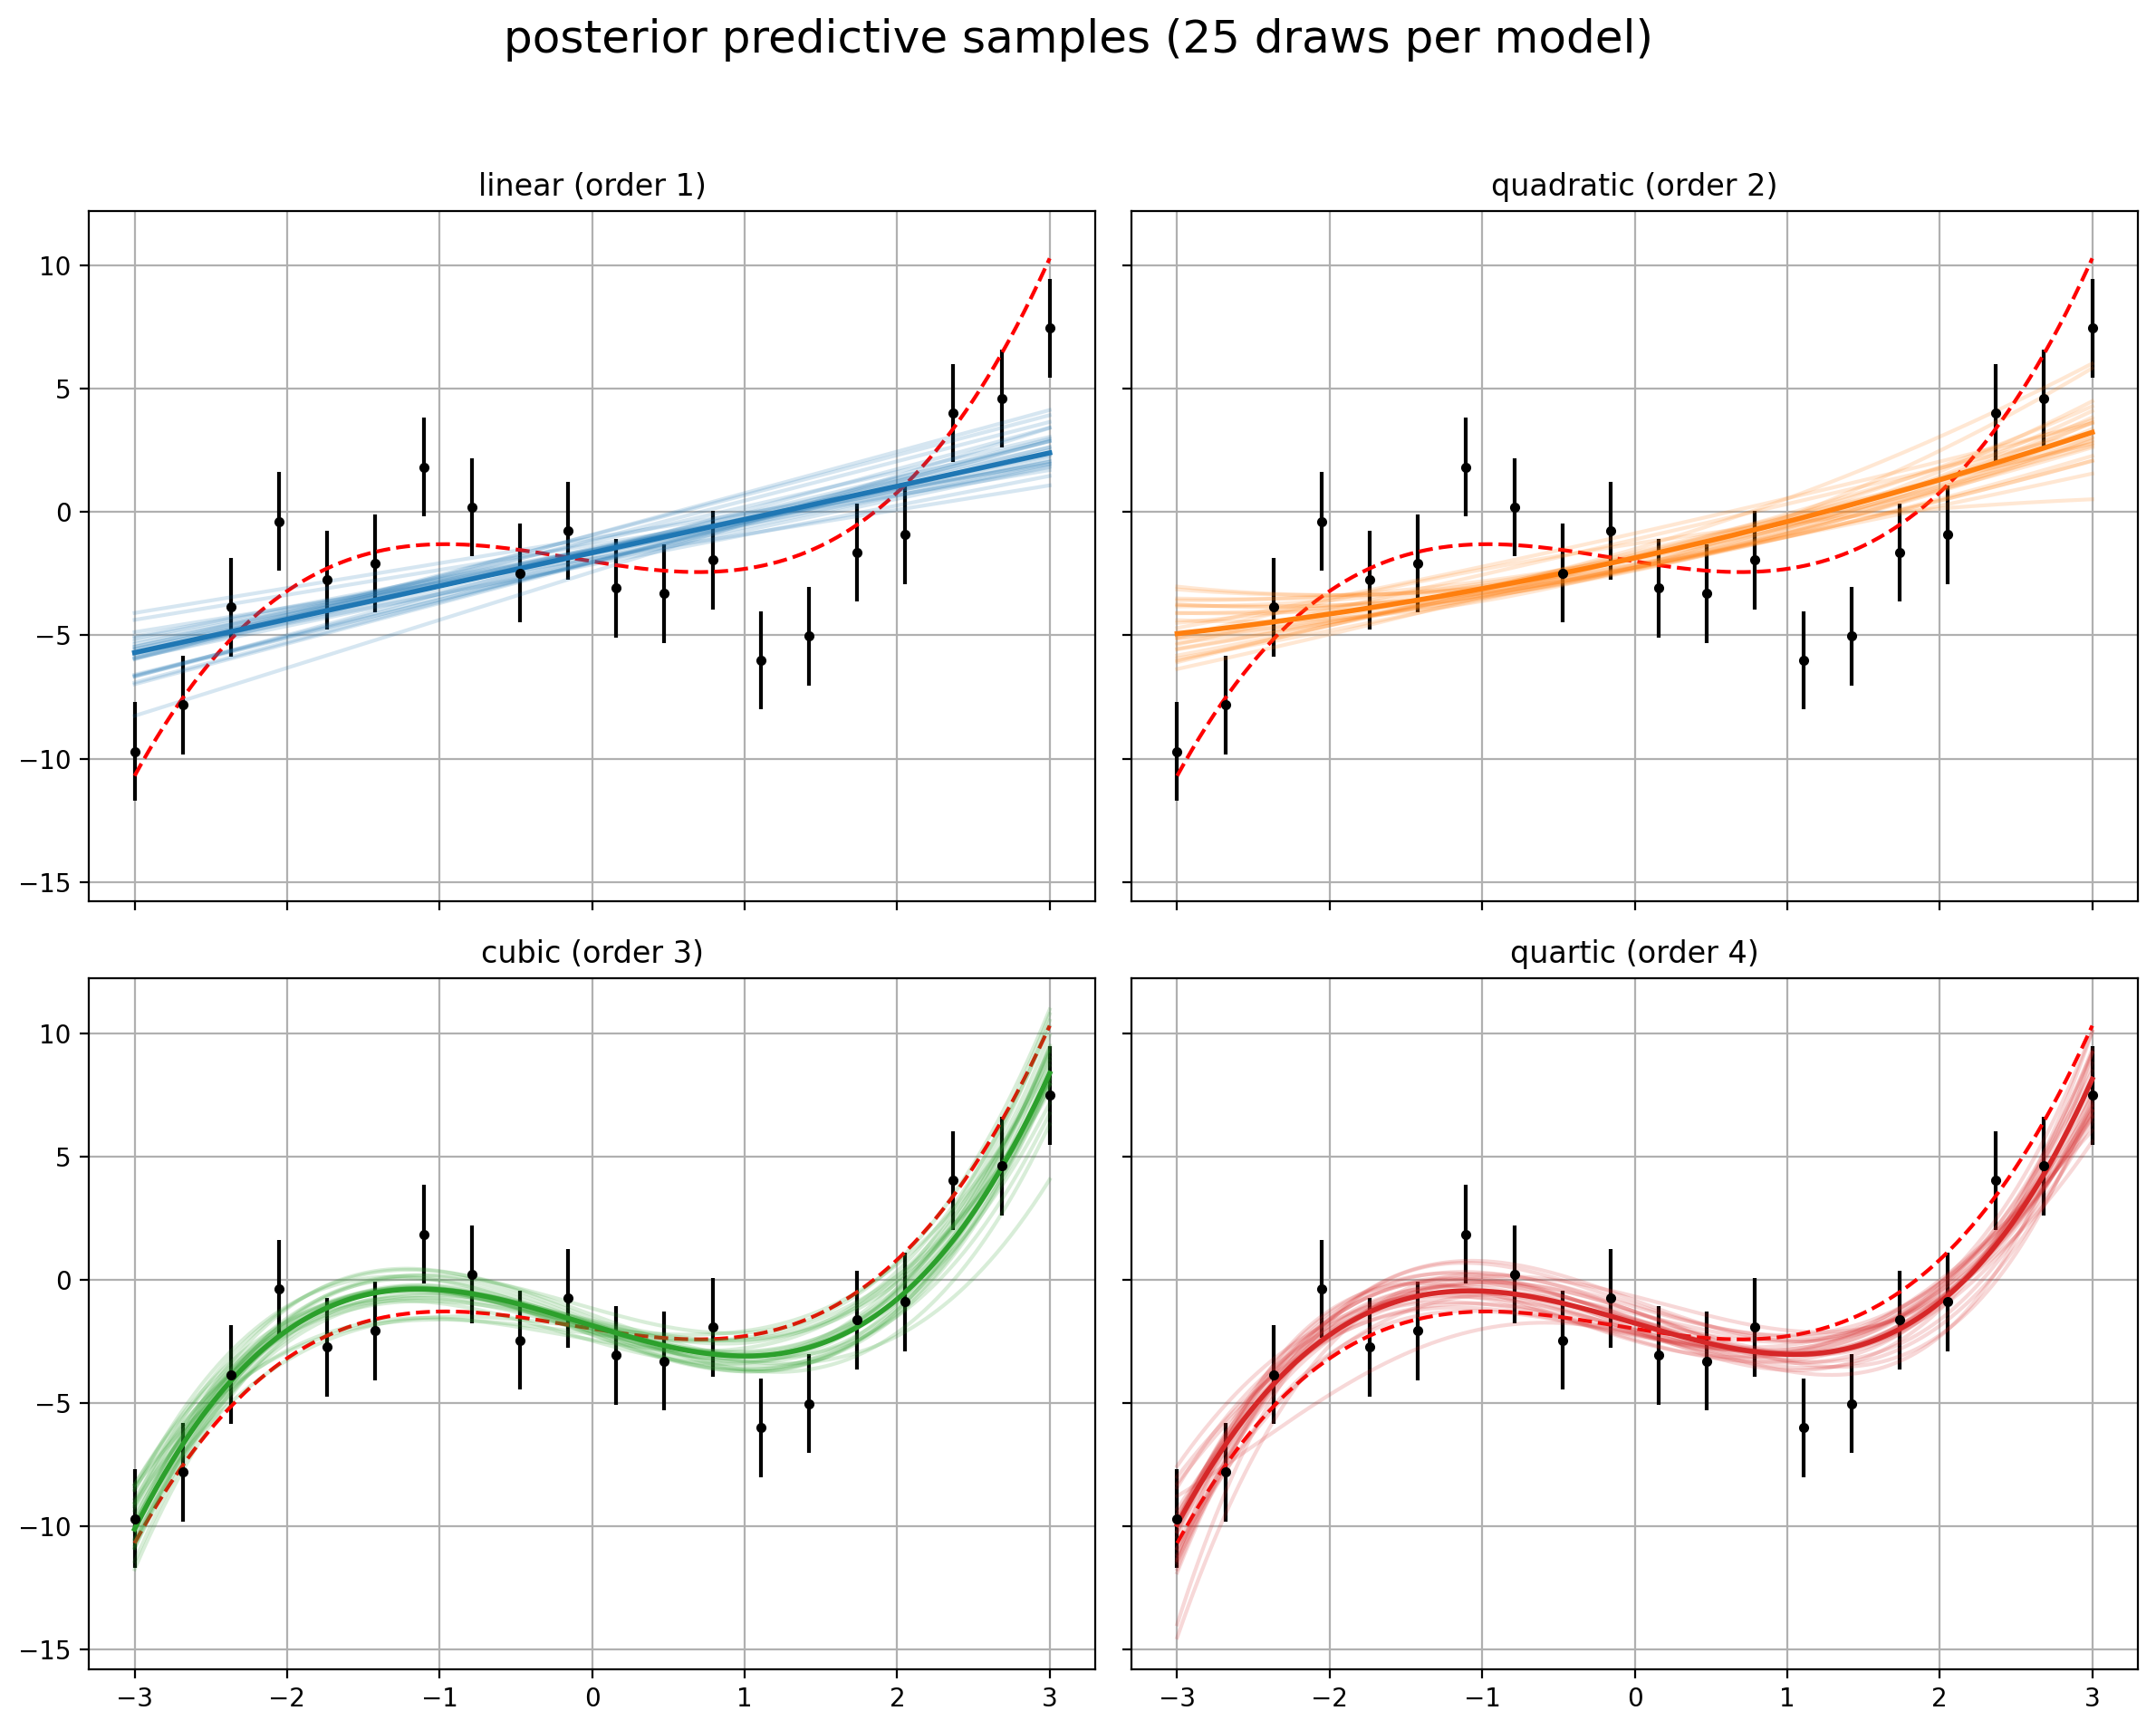

In [ ]:
fig1 = plot_posterior_predictives(
    samples_dict=samples_for_plot,
    x_data=x_data,
    y_data=y_data,
    x_plot=x_plot,
    truth_curve=_truth_curve,
    noise_std=noise_std,
)
plt.show()

## Plot the model probabilities

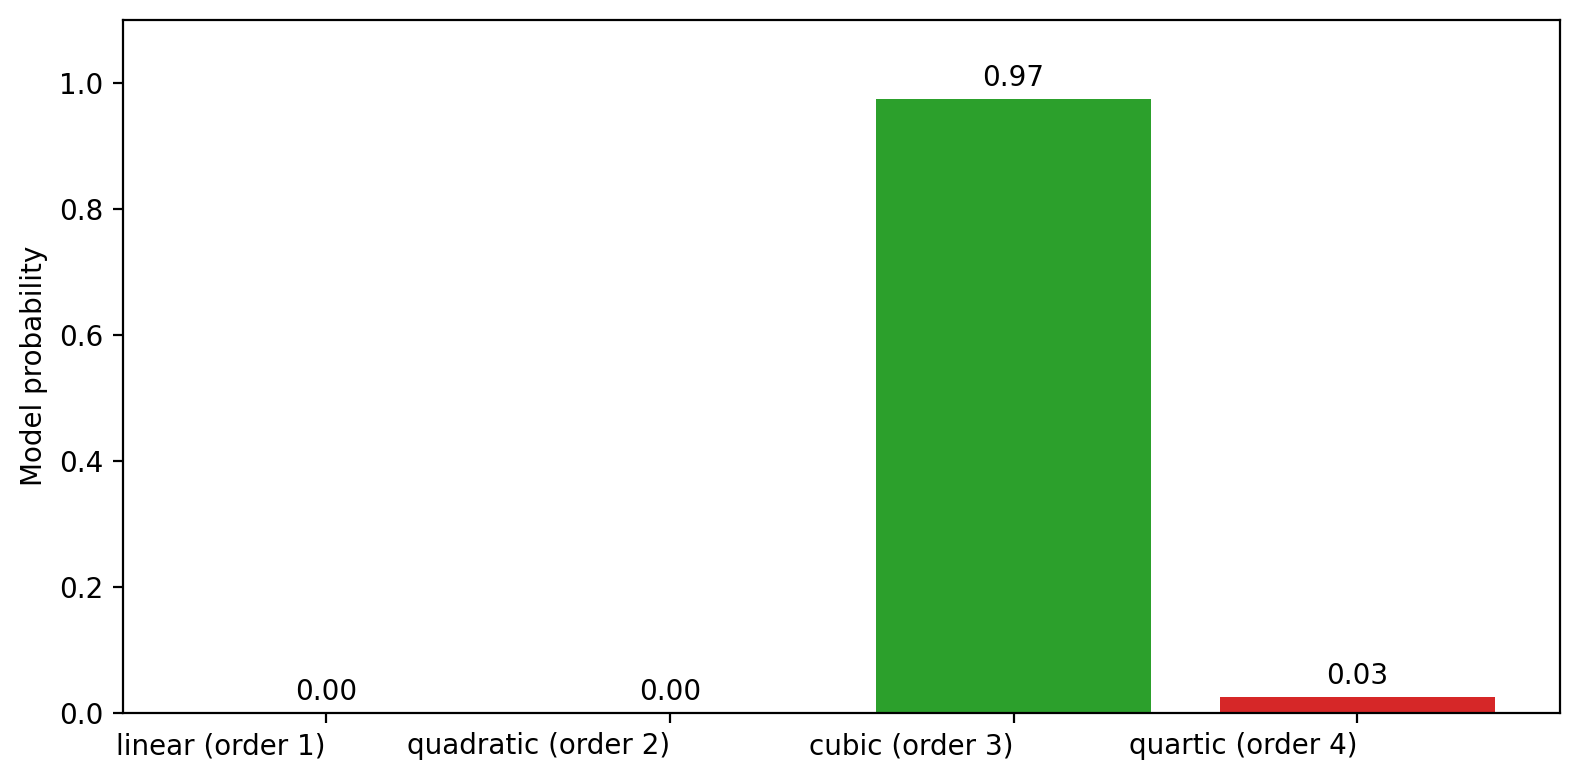

In [ ]:
fig2 = plot_model_probabilities(
    ln_Zs=[ln_Z_linear, ln_Z_quadratic, ln_Z_cubic, ln_Z_quartic],
    labels=[
        "linear (order 1)",
        "quadratic (order 2)",
        "cubic (order 3)",
        "quartic (order 4)",
    ],
)
plt.show()